<a href="https://colab.research.google.com/github/spapadiamantis/irony_detection_thesis/blob/master/thesis_dit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEP LEARNING FOR IRONY DETECTION

This python notebook was developed as a part of my Bachelor Thesis at DIT-UOA.

In this notebook I developped a neural network model for irony detection in short texts using a deep CNN architecture.

# Importing libraries and data



In this notebook we use the [Keras API](https://keras.io/) of [Tensorflow](https://www.tensorflow.org/) to develop our machine learning model  and for some parts of  preprocessing  as well. In preprocessing [Sklearn](https://scikit-learn.org/stable/) utensils and [NLTK ](https://www.nltk.org)are also used. We also use Numpy and Pandas for data manipulation.

In [0]:
!pip install langid

    100% |████████████████████████████████| 1.9MB 12.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/29/bc/61/50a93be85d1afe9436c3dc61f38da8ad7b637a38af4824e86e
Successfully built langid


In [0]:
import numpy as np #used  for data manipulation
import pandas as pd
from sklearn import utils as ut
import json          #used to save the model
import keras         #importing Tenorflow's Keras API and preprocessing tools
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
import nltk          # impoting NLTK to use for stopwords removal
nltk.download('stopwords')
import tensorflow as tf
from keras import regularizers
nltk.download('punkt')
from langid import classify #used for language filtering
from textblob import TextBlob #used for spell corrections and sentiment analysis


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Reading data from .csv file and removing stopwords using the natural language toolkit. 
For our data set we used a 1.100.000 line csv file containing Reddit comments labeled as 
ironic or non-ironic.

Dataset repo: https://www.kaggle.com/danofer/sarcasm

To run this cell properly you have to upload the "train-balanced-sarcasm.csv" to your files.

The initial csv file consisted of 10 columns comprising of various types of data like the number of downvotes and upvotes for the comment, the sumbreddit, parent comment and other.  I decided to only use the content of the comments as a feature dropping the rest.

Importing data from csv file using pandas function. Creating a pandas data frame

In [0]:
#reading csv data. We skip certain lines because the data file was 
#corrupted and we could not properly import
data = pd.read_csv('train-balanced-sarcasm.csv',skiprows= [997045,112610,291851])
print("Dataset columns:")
#print(list(dataset.columns.values))
print("Initial dataframe shape: ",data.shape)
data = data[['label','comment']]

print("Dataframe shape for eperiment: ",data.shape)

Dataset columns:
Initial dataframe shape:  (1010823, 10)
Dataframe shape for eperiment:  (1010823, 2)


#Preprocessing

##  Basic dataset cleaning

The initial dataset contained a lot of information that as not useful for our 
experiment. For the sake of conveniance and resource economy, I created a new csv data file after performing some basic operations on the data set. 

As a first step of preprocessing I decided to perform language filtering on the dataset, using the [TextBlob](https://textblob.readthedocs.io/en/dev/quickstart.html) WordNet integration, subsequently eliminating non-english comments. Through this process around 150000 comments were eliminated

I then used spelling corrections and performed lexicon-based sentiment analysis using the same library. The idea behind this is creating an extra feature for the model to train if needed.

In this cell I also include a very simple progress tracer, that I found online because of the size of the data set. It can be used for development reasons and appears commented in the code.

In [0]:
#Defining tracer functions

def progress_coroutine(print_on = 10000):
    print("Starting progress monitor")

    iterations = 0
    while True:
        yield
        iterations += 1
        if (iterations % print_on == 0):
            print("{} iterations done".format(iterations))
           
          
def trace_progress(func, progress = None):
    def callf(*args, **kwargs):
        if (progress is not None):
            progress.send(None)

        return func(*args, **kwargs)

    return callf

In [0]:
#Language filtering

#Applying pandas  lambda function to create a new dataframe column with language tags
data['langid']= data['comment'].dropna().apply(lambda x: classify(x)[0])
#co1 = progress_coroutine()
#data['langid']= data['comment'].dropna().apply(trace_progress((lambda x: classify(x)[0]),progress = co1))

#dropping comments
data = data[data['langid'] == 'en']
#printing datashape to see how many comments were dropped
#print("Datashape after language filtering: " data.shape)


#Sentiment analysis 
data['sentiment'] = data['comment'].apply(lambda x: TextBlob(x).sentiment)
#splittin sentiment analysis tuple into separate columns
data['polarity'] = data['sentiment'].apply(lambda x: x[0] )
data['subjectivity'] = data['sentiment'].apply(lambda x: x[1] )
#co3 = progress_coroutine()
#data['sentiment'] = data['comment'].apply(trace_progress((lambda x: TextBlob(x).sentiment),progress = co3))


"""
#Spelling Correction
#commented for being computationally expensive
co2 = progress_coroutine()
data['comment'] = data['comment'].apply(trace_progress((lambda x: TextBlob(x).correct()),progress = co2))

""" 

#Droping features I won't be using
dataset = data[['label','comment','polarity','subjectivity']]

dataset.to_csv("clean_set.csv", sep=',', encoding='utf-8')




## Text preprocessing

In this section I perform text preprocessing after having dropped any unnecessary data. To reduce noise we initially clean text at character level, removing punctuation and numbers, using regular expressions. We then tokenize every string, perform stopwords removal and stemming using the NLTK Lancaster stemmer.

In [0]:

# Simple stemming function for sentences 
from nltk.tokenize import sent_tokenize, word_tokenize

def stemSentence(sentence):
    
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lancaster.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [0]:
#This is just loading code for the clean csv file
#in case you have already processed it
data = pd.read_csv('clean_set.csv',skiprows= [12693,24722,997045,112610,291851]) 
print(data.shape)
print(list(data.columns.values))

data = data[['label','comment']]

In [0]:
from nltk.corpus import stopwords
from sklearn.utils import shuffle
import string
from nltk.stem import LancasterStemmer

stop = stopwords.words('english')  #downloading stopwords


#staring preprocessin
import re
#removing punctuation and numbers from texts
#data['comment'] = data['comment'].str.translate(None, string.punctuation)

data['comment'] =  data['comment'].str.replace('[^\w\s]','')
data['comment'] =  data['comment'].str.replace('[0-9]+','')
#data['comment'] = data['comment'].apply(lambda x: TextBlob(x).correct())
#creating a sentiment analysis feature to use while training and validation

lancaster=LancasterStemmer()
data['comment'] = data['comment'].dropna().apply(lambda x: stemSentence(x))



#splitting comments and changing uppercase to lowercase 
data['comment'] = data['comment'].str.lower().str.split()
#removing stopwords
data['comment'] = data['comment'].dropna().apply(lambda x: [item for item in x if item not in stop])


#creating dataset and shuffling containts using sklearn
dataset = data[['label','comment']]
dataset = shuffle(dataset)

#printing dataset to visualize he final shape of the data
print(dataset.shape)



(954151, 2)


In [0]:
#this is a code snippet to normalize sentiment polarity  if used

data['polarity'] = data['polarity'].dropna().apply(lambda x: 1 if x >0 )
data['polarity'] = data['polarity'].dropna().apply(lambda x: -1 if x<0)
data['polarity'] = data['polarity'].dropna().apply(lambda x: 0 if x==0)

## Preparing data 

The input layer of our model is comprised of an Embedding layer. In order to train those embeddings it is imperative that we encode our texts in some way and adjust them to specific length. To achieve this I used one hot encoding for all comments and then padded the texts to a maximum length of 20.



In [0]:

dataset_x = dataset[['comment']]
#print(dataset_x)

vocab_size = 20000 # number of words in our vocabulary 

#encoding texts using one hot encoding
encoded_docs = [one_hot(str(d), vocab_size) for d in dataset_x['comment'] ]
print(encoded_docs)
max_length = 20

#padding texts
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

#reseting dataset as the padded versionof itself
dataset_x = padded_docs
#print(dataset_x)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



I  then perform data spitting to create the dataset I am going to train my model on,  dividing data into training and testing data sets. We used the first 800.000 texts for training and the last 100.000 for testing.
We then split the comments and labels

In [0]:
dataset_x_final = pd.DataFrame(dataset_x)
dataset_y_final = pd.DataFrame(dataset['label'])

print(dataset_x_final.shape)
train_x = dataset_x_final.head(800000)

test_x = dataset_x_final.tail(100000)

train_y = dataset_y_final.head(800000)

test_y = dataset_y_final.tail(100000)


(954151, 20)


# Model compiling, training and testing

Using the keras API we created a neural network model to detect irony in small texts. using the sequential method we defined the network's architecture and subsquently we trained and tested its efficiency.

Our model is a deep-learning model comprised of an embedding layer used as an input layer. in our expirement we learned our own embeddings using an one hot encoding of the data. Three subsequent layers comprised of pairs of CNNs and Max Pooling. We also added Dropout to the end of each CNN to avoid overffiting phenomena. Finally we a Dense layer as output.


In [0]:
#importing layers 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D,MaxPooling1D, Flatten
from keras.layers import LSTM , Embedding
from keras.regularizers import l2

#Bulding the model architecure using the Sequentia API
model = Sequential()
model.add(Embedding(50000, 128, input_length=20))
model.add(Dropout(0.5))
model.add(Conv1D(264, 5, activation='relu'))#,bias_initializer='glorot_uniform',kernel_initializer='glorot_uniform'))
model.add(MaxPooling1D(pool_size=3))
model.add((Dropout(0.25)))
model.add(Conv1D(128, 5, activation='relu'))#,bias_initializer='glorot_uniform',kernel_initializer='glorot_uniform'))
model.add(MaxPooling1D(pool_size=1))
model.add((Dropout(0.25)))
model.add(Conv1D(32, 1 ,activation='relu'))#,bias_initializer='glorot_uniform',kernel_initializer='glorot_uniform'))
model.add(MaxPooling1D(pool_size=1)) #global max pooling layer
model.add((Dropout(0.25)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))

In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 128)           6400000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 264)           169224    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 264)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 264)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 128)            169088    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 128)            0         
__________

After defining the architecture of the model using the Keras API we compile it and train it on our training dataset. 

In [0]:
#this is a custom metric used while training
#in order to use the metric you have
#to add this callback to the fitting function

from sklearn.metrics import f1_score

class Metrics(keras.callbacks.Callback):
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = self.validation_data[1]
        self.f1s=f1_score(targ, predict)
        return


      
metrics = Metrics()

In [0]:
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam

opt = keras.optimizers.Adam(lr=0.001)

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=1, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

model.compile(loss='mean_squared_logarithmic_error',
  optimizer=opt,
  metrics=['accuracy'])

history = model.fit(train_x, train_y,
  batch_size=128,
  epochs=10,
  verbose=1,
  #callbacks=callbacks_list,
  validation_split=0.2,
  shuffle=True)


Train on 640000 samples, validate on 160000 samples
Epoch 1/10
640000/640000 [==============================] - 1174s 2ms/step - loss: 0.1020 - acc: 0.6516 - val_loss: 0.0970 - val_acc: 0.6703
Epoch 2/10
640000/640000 [==============================] - 1163s 2ms/step - loss: 0.0959 - acc: 0.6804 - val_loss: 0.0964 - val_acc: 0.6822
Epoch 3/10
640000/640000 [==============================] - 1157s 2ms/step - loss: 0.0931 - acc: 0.6942 - val_loss: 0.0970 - val_acc: 0.6810
Epoch 4/10
640000/640000 [==============================] - 1171s 2ms/step - loss: 0.0905 - acc: 0.7055 - val_loss: 0.0983 - val_acc: 0.6841
Epoch 5/10
640000/640000 [==============================] - 1171s 2ms/step - loss: 0.0886 - acc: 0.7129 - val_loss: 0.0981 - val_acc: 0.6738
Epoch 6/10
640000/640000 [==============================] - 1168s 2ms/step - loss: 0.0868 - acc: 0.7215 - val_loss: 0.0982 - val_acc: 0.6748
Epoch 7/10
640000/640000 [==============================] - 1162s 2ms/step - loss: 0.0852 - acc: 0.727

Finally we evaluate the model on our testing data-set

In [0]:
model.evaluate(x=test_x, y=test_y, batch_size=32, verbose=1, sample_weight=None, steps=None)

100000/100000 [==============================] - 15s 155us/step


[0.10148728538632393, 0.66862]

# Visualising results

In this section I  created graphic representations  to better visualize the model's attributes. In the first part you can find a bi-dimenstional visualization of the embeddings, and a simple plot of the metrics over epochs trained

In [0]:
import plotly.plotly as py
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.graph_objs as go

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


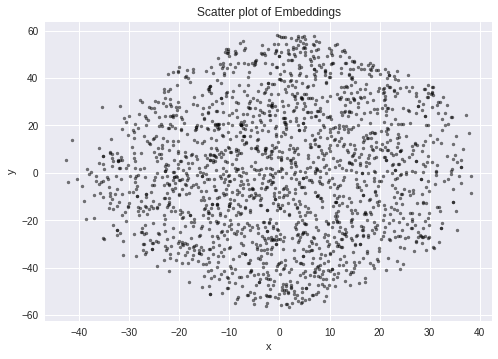

In [0]:


## Get weights
conv_embds = model.layers[0].get_weights()[0]
## Plotting function

def plot_words(data, start, stop, step):
  x = data[start:stop:step,0]
  y = data[start:stop:step, 1]
  colors = (0,0,0)
  area = np.pi*3
  plt.scatter(x, y, s=area, c=colors, alpha=0.5)
  plt.title('Scatter plot of Embeddings')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

## Visualize words in two dimensions 
conv_tsne_embds = TSNE(n_components=2).fit_transform(conv_embds)
plot_words(conv_tsne_embds, 0, 2000, 1)



#plt.plot(conv_tsne_embds)

By using the history structure of the Keras API we can easily plot the progress of our metrics such as, training and validation, accuracy and loss.

In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

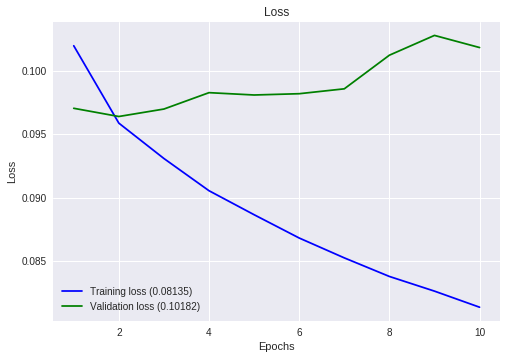

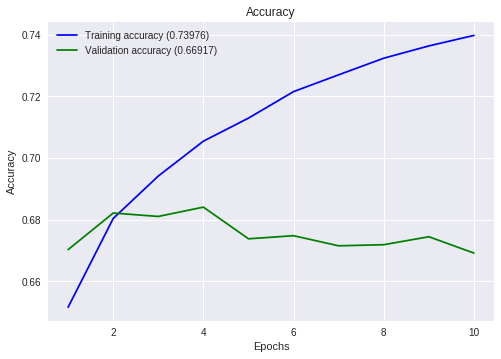

In [0]:
plot_history(history)